## 🧩 Environment Setup & Reproducibility

This section prepares the runtime environment and ensures reproducibility across experiments.

### Key Steps
1. **Import Core Libraries:**  
   Includes PyTorch, NumPy, OpenCV, Matplotlib, and project utilities.  
   The working directory is appended to `sys.path` so that `src/` modules can be imported easily.

2. **Set Random Seeds:**  
   Fixes seeds for `random`, `numpy`, and `torch` to make results reproducible.  
   Deterministic cuDNN settings are enabled for consistent model behavior (may reduce speed slightly).

3. **Select Compute Device:**  
   Automatically chooses **CUDA GPU** if available, otherwise defaults to CPU.  
   Prints concise environment info (PyTorch version, CUDA version, and device name).

4. **Define Dataset Paths:**  
   Paths for `images/` and `masks/` are defined.  
   You can override them via environment variables `KVASIR_IMG_DIR` and `KVASIR_MASK_DIR`.

5. **Path Validation:**  
   Checks whether image and mask directories exist before proceeding to prevent runtime errors.

6. **Set Core Hyperparameters:**  
   - `IMG_SIZE`: input image resolution (commonly 256/384/512 for Kvasir-SEG).  
   - `BATCH_SIZE`: GPU memory dependent.  
   - `EPOCHS`: total training iterations.  
   - `LR`: learning rate for the optimizer.  
   - `VAL_SPLIT`: validation set ratio.

7. **Visualization Defaults:**  
   Adjusts Matplotlib DPI for sharper inline and saved figures in notebooks and reports.

> 💡 *Tip:* Keep this cell at the top of your notebook to ensure reproducibility and path correctness before running any training or visualization code.


In [1]:
# --- Standard & third-party imports ---
import os, sys, random, json, platform, glob
from pathlib import Path

import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# --- Keep project root importable (e.g., src/ modules) ---
sys.path.append(os.getcwd())

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# For strictly repeatable results; set to False if you prefer speed over determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Device selection & concise environment printout ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"[Env] Torch {torch.__version__} | CUDA {torch.version.cuda} | Device: {cuda_name}")

# --- Dataset paths (override via environment for portability/CI) ---
IMG_DIR  = os.environ.get("KVASIR_IMG_DIR",  "D:/Kvasir-Seg_Project/Kvasir-SEG/images")
MASK_DIR = os.environ.get("KVASIR_MASK_DIR", "D:/Kvasir-Seg_Project/Kvasir-SEG/masks")

IMG_DIR, MASK_DIR = Path(IMG_DIR), Path(MASK_DIR)

# Basic validation to fail fast with a clear message
if not IMG_DIR.exists() or not MASK_DIR.exists():
    raise FileNotFoundError(
        f"Dataset paths not found.\n  Images: {IMG_DIR}\n  Masks:  {MASK_DIR}\n"
        "Hint: Set KVASIR_IMG_DIR / KVASIR_MASK_DIR env vars or edit the paths above."
    )

num_imgs  = len(list(IMG_DIR.glob("*")))
num_masks = len(list(MASK_DIR.glob("*")))
print(f"[Data] Found {num_imgs} images and {num_masks} masks")

# --- Core hyperparameters ---
IMG_SIZE   = 256     # For Kvasir-SEG, 256/384/512 are common choices
BATCH_SIZE = 2       # Increase (e.g., 8) if GPU memory allows
EPOCHS     = 80
LR         = 1e-3
VAL_SPLIT  = 0.2

# --- Matplotlib defaults for sharper inline figures ---
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120


[Env] Torch 2.3.1+cu118 | CUDA 11.8 | Device: NVIDIA GeForce RTX 3050 Laptop GPU
[Data] Found 1000 images and 1000 masks


## Dataset Pair Listing

Before training, each input image must be correctly paired with its corresponding segmentation mask.  
This helper function `list_pairs()` scans both `images/` and `masks/` directories, matches them by filename,  
and returns a list of `(image_path, mask_path)` tuples.

### How It Works
1. Searches for images with the given extensions (`jpg`, `jpeg`, `png`).
2. For each image file, checks if a corresponding mask exists with the same base name.
3. Supports both `.png` and `.jpg` mask formats.
4. Raises an error if no valid pairs are found — ensuring dataset integrity.

> **Output:** `pairs` list, which will be used later in custom `Dataset` class for loading and training.


In [2]:
def list_pairs(img_dir, mask_dir, exts=("jpg", "jpeg", "png")):
    """
    Collects all (image, mask) file pairs from given directories.
    
    Args:
        img_dir (str): Directory containing input images.
        mask_dir (str): Directory containing corresponding segmentation masks.
        exts (tuple): Valid image file extensions to search for.
        
    Returns:
        list: A list of (image_path, mask_path) tuples.
    """
    imgs = []
    # Gather all image paths with supported extensions
    for e in exts:
        imgs += sorted(glob.glob(os.path.join(img_dir, f"*.{e}")))

    pairs = []
    for ip in imgs:
        # Extract base filename without extension
        name = os.path.splitext(os.path.basename(ip))[0]
        # Construct mask path (default: .png)
        mp = os.path.join(mask_dir, f"{name}.png")

        # Fallback to .jpg mask if .png does not exist
        if not os.path.exists(mp):
            mp_j = os.path.join(mask_dir, f"{name}.jpg")
            if os.path.exists(mp_j):
                mp = mp_j

        # Only append if mask actually exists
        if os.path.exists(mp):
            pairs.append((ip, mp))

    if not pairs:
        raise FileNotFoundError("No image/mask pairs found. Please check dataset paths or file extensions.")

    return pairs


# --- Generate and verify dataset pairs ---
pairs = list_pairs(IMG_DIR, MASK_DIR)
print(f"[Data] Total image–mask pairs found: {len(pairs)}")



[Data] Total image–mask pairs found: 1000


## Preprocessing Pipeline Demonstration

This cell demonstrates the **multi-stage preprocessing pipeline** applied to colonoscopy images from the **Kvasir-SEG** dataset.  
The goal is to enhance visual quality and reduce illumination artifacts before training the U-Net model.

### Stages in the Pipeline
1. **Specular Highlight Removal:**  
   Removes bright reflection spots caused by endoscope lighting.

2. **Homomorphic Filtering:**  
   Corrects uneven illumination and improves local contrast in the Value (V) channel.

3. **Guided Filtering:**  
   Smooths noise while preserving important edges and boundaries.

4. **CLAHE (Contrast Limited Adaptive Histogram Equalization):**  
   Enhances local contrast without over-amplifying noise.

5. **Retone Adjustment:**  
   Rebalances the tone of the V-channel to match a target dynamic range, leading to consistent brightness.

Finally, the notebook visualizes both the **original** and **preprocessed** images side by side for comparison.

> 💡 *Tip:* These preprocessing stages are modular — you can enable or disable specific filters in `src/preprocessing/pipeline.py` depending on your dataset or experimental setup.


In [120]:
import sys, os
sys.path.append(os.path.abspath(".."))


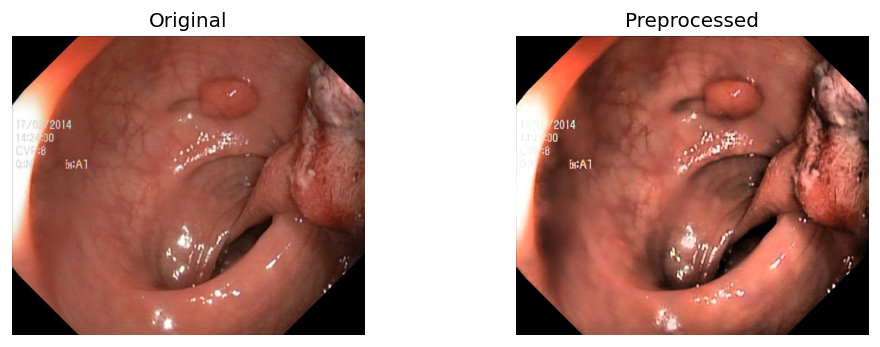

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))  # Allow importing from src/ when running from notebooks/

# --- Import modular preprocessing functions ---
from src.preprocessing.specular_removal import remove_specular_highlight_safe
from src.preprocessing.homomorphic_filter import homomorphic_filter_soft
from src.preprocessing.guided_filter import guided_filter
from src.preprocessing.clahe import apply_clahe
from src.preprocessing.retone import retone_to_target


def preprocess_staged_rgb_single(bgr):
    """
    Apply a staged preprocessing pipeline to a single BGR image.
    Each stage enhances visual quality and supports better segmentation results.
    
    Args:
        bgr (np.ndarray): Input image in BGR format (OpenCV default).
    Returns:
        np.ndarray: Preprocessed image (BGR).
    """

    # 1️⃣ Specular highlight removal (reduce bright reflection spots)
    bgr1, _ = remove_specular_highlight_safe(bgr)

    # 2️⃣ Homomorphic filtering on V channel (illumination correction)
    h, s, v = cv2.split(cv2.cvtColor(bgr1, cv2.COLOR_BGR2HSV))
    v = homomorphic_filter_soft(v)
    bgr2 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)

    # 3️⃣ Guided filtering (edge-preserving smoothing)
    h, s, v = cv2.split(cv2.cvtColor(bgr2, cv2.COLOR_BGR2HSV))
    v = guided_filter(v)
    bgr3 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)

    # 4️⃣ CLAHE (local contrast enhancement)
    h, s, v = cv2.split(cv2.cvtColor(bgr3, cv2.COLOR_BGR2HSV))
    v = apply_clahe(v)
    bgr4 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)

    # 5️⃣ Retone adjustment (normalize tone distribution)
    h, s, v = cv2.split(cv2.cvtColor(bgr4, cv2.COLOR_BGR2HSV))
    v = retone_to_target(v)
    bgr5 = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)

    return bgr5


# --- Demonstrate the preprocessing pipeline on a sample pair ---
ip, mp = pairs[3]  # Select one sample image–mask pair
orig = cv2.imread(ip)
prep = preprocess_staged_rgb_single(orig)

# --- Visualization of Original vs. Preprocessed ---
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(prep, cv2.COLOR_BGR2RGB))
plt.title("Preprocessed")
plt.axis("off")

plt.tight_layout()
plt.show()


## Custom Dataset & Data Loaders

This section defines a lightweight `KvasirSegDataset` for pairing images with their binary masks and preparing mini-batches.

### What the dataset does
- **Reads** an RGB input and a **binary** mask (`m >= 128 → 1 else 0`).
- **Applies preprocessing** via the staged pipeline (`preprocess_staged_rgb_single`).
- **Augments** (train-time only): random **horizontal flip** with `p=0.5`.  
  > Minimal by design; extend later with rotation, scaling, color jitter, etc., if needed.
- **Resizes** to a fixed square (`IMG_SIZE`) and keeps mask integrity with **nearest-neighbor** interpolation.
- **Normalizes** pixel values to `[0, 1]` and converts to **CHW** tensors (`float32`).

### Train/Validation split
- Uses a **random split** based on `VAL_SPLIT` (seeded earlier for reproducibility).
- Builds two `DataLoader`s with shuffling for train and deterministic order for validation.
- `pin_memory=True` is enabled to speed up host→device transfers when using CUDA.

### Tips
- For stronger augmentation, consider `albumentations` (elastic transforms, shifts/scales/rotations).
- For more stable optimization, add **mean/std normalization** (e.g., ImageNet stats) in the dataset.
- When running on Linux, you can increase `num_workers` (e.g., 2–4) for faster loading.


In [4]:
class KvasirSegDataset(Dataset):
    def __init__(self, pairs, img_size=256, is_train=True):
        """
        Minimal dataset for Kvasir-SEG: loads (image, mask), preprocesses,
        augments (optionally), resizes, normalizes, and returns tensors.
        """
        self.pairs = pairs
        self.size = img_size
        self.is_train = is_train

    def __len__(self):
        return len(self.pairs)

    def _aug(self, x, y):
        """Train-time horizontal flip with p=0.5 (kept minimal by design)."""
        if self.is_train and random.random() < 0.5:
            x = np.ascontiguousarray(np.flip(x, 1))
            y = np.ascontiguousarray(np.flip(y, 1))
        return x, y

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]

        # Read image (BGR) and mask (grayscale). Binarize mask at 128.
        bgr = cv2.imread(ip)
        m = cv2.imread(mp, 0)
        m = (m >= 128).astype(np.uint8)

        # Apply staged preprocessing (specular removal, homomorphic, guided, CLAHE, retone)
        bgr = preprocess_staged_rgb_single(bgr)

        # Convert to RGB for visualization/consistency
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        # Minimal augmentation
        rgb, m = self._aug(rgb, m)

        # Resize image & mask; keep mask crisp with nearest-neighbor
        rgb = cv2.resize(rgb, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        m   = cv2.resize(m,   (self.size, self.size), interpolation=cv2.INTER_NEAREST)

        # To tensors: image → [0,1] float32 CHW, mask → float32 [1,H,W]
        x = (rgb.astype(np.float32) / 255.0).transpose(2, 0, 1)
        y = m.astype(np.float32)[None, ...]

        return torch.from_numpy(x), torch.from_numpy(y)


# --- Train/Val split (seeded earlier for reproducibility) ---
random.shuffle(pairs)
n_val = int(VAL_SPLIT * len(pairs))
tr, va = pairs[:-n_val], pairs[-n_val:]

# --- DataLoaders ---
train_loader = DataLoader(
    KvasirSegDataset(tr, IMG_SIZE, is_train=True),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      # increase (e.g., 2-4) on Linux for speed
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    KvasirSegDataset(va, IMG_SIZE, is_train=False),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Quick sanity check
xb, yb = next(iter(val_loader))
print("Batch X:", xb.shape, "| Batch Y:", yb.shape, "| dtype:", xb.dtype, yb.dtype)


Batch X: torch.Size([2, 3, 256, 256]) | Batch Y: torch.Size([2, 1, 256, 256]) | dtype: torch.float32 torch.float32


## Training Loop, Validation, and Checkpointing

This section implements a compact yet reliable training pipeline for binary segmentation with U-Net.

### Components
- **Loss:** `BCEDiceLoss` (balanced BCE + soft Dice) to stabilize early training and optimize overlap.
- **Optimizer:** `Adam` with a fixed learning rate (can be paired with a scheduler later).
- **Metrics:** Mean **Dice** and **IoU** computed on **sigmoid probabilities** (no hard threshold during validation).
- **Checkpointing:** Saves the **best** model by validation **Dice** score.
- **Progress:** Uses `tqdm` for per-epoch data loader progress and prints a concise epoch summary.

### Notes & Options
- If your metric helpers (`dice_coeff`, `iou_score`) expect hard masks, ensure they **internally** handle thresholding (e.g., `p>0.5`).  
  Here we pass **probabilities** after `sigmoid` for smoother metric behavior.
- Consider adding:
  - **Mixed precision** (`torch.cuda.amp`) for faster training on GPUs,
  - **Early stopping** based on patience,
  - **LR scheduler** (e.g., `ReduceLROnPlateau`) for more stable convergence.


In [5]:
from src.training.losses import BCEDiceLoss
from src.utils.metrics import dice_coeff, iou_score
from tqdm import tqdm
import time
import numpy as np

def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    One full pass over the training loader.
    Returns the average loss over all samples.
    """
    model.train()
    running = 0.0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running += loss.item() * xb.size(0)

    return running / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device):
    """
    Evaluation on validation data.
    Returns average loss, mean Dice and mean IoU across the validation set.
    """
    model.eval()
    running = 0.0
    dices, ious = [], []

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)
        running += loss.item() * xb.size(0)

        # Compute metrics on probabilities (post-sigmoid)
        probs = torch.sigmoid(logits)
        dices.append(dice_coeff(probs, yb))
        ious.append(iou_score(probs, yb))

    val_loss = running / len(loader.dataset)
    mean_dice = float(np.mean(dices))
    mean_iou  = float(np.mean(ious))
    return val_loss, mean_dice, mean_iou


def fit_model(build_fn, name, epochs=EPOCHS, lr=LR):
    """
    Build a model via `build_fn()`, train/validate for the given number of epochs,
    and save the best checkpoint by validation Dice score.

    Returns:
        model: trained model (last-epoch weights loaded)
        history: dict with 'train_loss', 'val_loss', 'dice', 'iou'
    """
    model = build_fn().to(DEVICE)
    criterion = BCEDiceLoss(bce_weight=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ckpt_dir = f"checkpoints/{name}"
    os.makedirs(ckpt_dir, exist_ok=True)

    best_dice = -1.0
    history = {"train_loss": [], "val_loss": [], "dice": [], "iou": []}

    print(f"\n### Training {name}")
    for ep in range(1, epochs + 1):
        t0 = time.time()

        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        va_loss, dice, iou = validate(model, val_loader, criterion, DEVICE)

        dt = time.time() - t0
        print(f"Epoch {ep:02d} | tr {tr_loss:.4f} | va {va_loss:.4f} | Dice {dice:.4f} | IoU {iou:.4f} | {dt:.1f}s")

        # Track history for later plotting
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["dice"].append(dice)
        history["iou"].append(iou)

        # Save best by Dice
        if dice > best_dice:
            best_dice = dice
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "best.pth"))

        # Always save the "last" weights as well (useful for debugging)
        torch.save(model.state_dict(), os.path.join(ckpt_dir, "last.pth"))

    print(f"[{name}] Best Dice: {best_dice:.4f}")
    return model, history


## U-Net Model Builder

This cell defines a small factory to build the U-Net segmentation model.

### Design Notes
- **Input/Output channels:** `in_ch=3` for RGB images, `out_ch=1` for binary masks.
- **Capacity knob (`base`):** controls the number of base feature maps (e.g., 16/32/64).  
  Larger values increase model capacity and memory usage.
- **Extensibility:** keep this builder minimal so it’s easy to swap architectures (e.g., ResUNet, Attention-UNet).
- **(Optional) PyTorch 2:** you can wrap the model with `torch.compile(model)` for potential speedups.


In [7]:
from src.models.unet import UNet
import torch

MODEL_NAME = "unet"
UNET_BASE  = 32  # Base number of feature maps; increase for higher capacity

def build_unet(base: int | None = None) -> torch.nn.Module:
    """
    Factory function to instantiate a U-Net model for binary segmentation.

    Args:
        base (int | None): Base number of feature maps. If None, uses UNET_BASE.
                           Typical values: 16, 32, 64 (trade-off between speed & accuracy).

    Returns:
        torch.nn.Module: U-Net instance with RGB input and single-channel output.
    """
    b = UNET_BASE if base is None else int(base)
    model = UNet(in_ch=3, out_ch=1, base=b)

    # Optional (PyTorch 2.0+): compile for potential runtime speedup
    # try:
    #     model = torch.compile(model)
    # except Exception:
    #     pass  # Safe fallback if compile is unavailable

    return model


## Paths, Checkpoint Helpers & Runtime Flags

This section centralizes I/O paths, run metadata saving, and safe checkpoint loading for U-Net experiments.

### Runtime Flags
- `USE_AMP`: **Automatic Mixed Precision** toggle (default `False`).  
  Turn **on** only after verifying numerical stability on your GPU (requires `torch.cuda.amp` integration in the train loop).
- `MIN_DEL`: Small epsilon (e.g., for numeric stability in metrics/loss).  
  > If unused in your codebase, it can be removed.

### Path Management
- `_paths_for_unet()`  
  Creates/returns a results directory under `assets/results/{MODEL_NAME}` and the canonical checkpoint path `best_{MODEL_NAME}.pth`.  
  Keeps artifacts organized per model name.

- `_save_run_summary(meta: dict)`  
  Persists a **JSON** summary (`summary.json`) of the current run (e.g., hyperparameters, scores, timestamps).  
  Useful for reproducibility and downstream reporting (e.g., `docs/RESULTS.md`).

### Safe Checkpoint Loading
- `_load_best_if_exists(build_fn)`  
  1) Loads the checkpoint **on CPU** first (`map_location="cpu"`) to avoid device mismatch/OOM issues.  
  2) **Infers** the U-Net base width from the state dict (see below) to rebuild the exact architecture.  
  3) Instantiates the model with the inferred base, **loads weights** (`strict=True`), then moves to `DEVICE`.  
  4) Sets `eval()` and **skips training** if a best checkpoint is present.

  > If you anticipate partial/renamed keys (e.g., after refactors), consider `strict=False` or a key-renaming shim.  
  > On PyTorch ≥ 2.4, you may also use `torch.load(..., weights_only=True)` for extra safety.

### Base-Width Inference
- `_infer_unet_base_from_state(state_dict, default=UNET_BASE)`  
  Heuristically detects the **base feature count** from the first encoder block weight shape (e.g., `enc1.conv.0.weight → [C_out, C_in, k, k]`).  
  Falls back to `UNET_BASE` if keys don’t match.

### Practical Notes
- Checkpoint directory is nested under `assets/results/{MODEL_NAME}` to keep outputs version-controlled (small files) and visually organized.  
  If checkpoints are large, consider adding that path to `.gitignore` and only committing `summary.json` + plots.
- If `DEVICE` is CUDA and you encounter OOM when moving the model, the code **gracefully stays on CPU** and logs a warning.
- To keep experiments comparable, write additional fields into `summary.json` (e.g., seed, img size, best Dice/IoU, training time).


In [ ]:
import os, json, time, platform
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

MIN_DEL = 1e-4
USE_AMP = False  # set True if you confirm stability on your GPU

def _paths_for_unet():
    d = os.path.join("assets", "results", MODEL_NAME)
    os.makedirs(d, exist_ok=True)
    return d, os.path.join(d, f"best_{MODEL_NAME}.pth")

def _save_run_summary(meta: dict):
    d, _ = _paths_for_unet()
    with open(os.path.join(d, "summary.json"), "w") as f:
        json.dump(meta, f, indent=2)

def _load_best_if_exists(build_fn):
    d, best_pth = _paths_for_unet()
    if os.path.exists(best_pth):
        # 1) load state on CPU first
        state = torch.load(best_pth, map_location="cpu")

        # 2) infer base from checkpoint
        inferred_base = _infer_unet_base_from_state(state, default=UNET_BASE)
        if inferred_base != UNET_BASE:
            print(f"[{MODEL_NAME}] Checkpoint base={inferred_base} detected (current default={UNET_BASE}).")
        else:
            print(f"[{MODEL_NAME}] Checkpoint base matches current default: {UNET_BASE}.")

        # 3) build model with the inferred base
        m = build_unet(base=inferred_base)   # <-- IMPORTANT
        m.load_state_dict(state, strict=True)

        # 4) move to device
        try:
            m = m.to(DEVICE)
        except RuntimeError as e:
            print("[Warn] OOM while moving model to CUDA, staying on CPU:", e)

        m.eval()
        print(f"[{MODEL_NAME}] Found checkpoint → {best_pth}. Skipping training.")
        return m, True
    return None, False


# 6.1 — add these helpers (put under other helpers)
def _infer_unet_base_from_state(state_dict: dict, default=UNET_BASE):
    """
    Try to infer UNet 'base' (first block out-channels) from a state_dict.
    Looks for 'enc1.conv.0.weight' → shape [Cout, Cin, k, k].
    """
    key_candidates = [
        "enc1.conv.0.weight",  # our typical naming
        "down1.conv.0.weight", # alternative
        "encoder1.conv.0.weight"
    ]
    for k in key_candidates:
        if k in state_dict and state_dict[k].ndim >= 1:
            return int(state_dict[k].shape[0])
    return int(default)



## Robust Train/Validation Loops (NaN guards, Grad Clipping, Optional AMP)

This section implements **defensive** training/evaluation helpers with a few safety nets for stable segmentation training.

### What happens here
- **`_train_one_epoch`**
  1. Sets `model.train()` and iterates over the train loader.
  2. Moves batches to `DEVICE` and zeros grads with `set_to_none=True` (slightly faster).
  3. **Forward → loss → backward → optimizer.step()**.
  4. **NaN/Inf guard:** If loss is not finite, the batch is skipped.
  5. **Gradient clipping:** `clip_grad_norm_` prevents exploding gradients.
  6. Accumulates sample-weighted loss to return **mean train loss**.

- **`_validate`**
  1. Sets `model.eval()` with `@torch.no_grad()` to disable grad tracking.
  2. Computes **mean val loss** over samples.
  3. Derives **probabilities** via `sigmoid(logits)`.
  4. Computes **Dice** and **IoU** (your snippet mixes soft Dice over the batch and hard IoU with a 0.5 threshold).

### Notes & recommendations
- **AMP integration:** Your function signature has `scaler=None` but AMP isn’t used yet.  
  If you set `USE_AMP=True`, wrap the forward pass with `autocast()` and use a `GradScaler` to scale/unscale grads.
- **Metric consistency:** Prefer using a single implementation (e.g., the ones in `src/utils/metrics.py`) so that **validation** and **test** report the **same definitions** (soft vs. hard, threshold choice).
- **Batch-wise metrics:** For more robust estimates, compute Dice/IoU per-image then average across the batch (instead of one global sum over the batch).
- **Epsilon (`1e-6`)**: keep a shared constant for numerical stability.
- **Non-blocking transfers:** Use `to(device, non_blocking=True)` when pin_memory is enabled in DataLoader.

> If you already have a training loop elsewhere (e.g., `train_one_epoch`/`validate` defined earlier), keep **one** canonical pair to avoid duplication and drift.


In [9]:
from torch.cuda.amp import autocast, GradScaler
from src.utils.metrics import dice_coeff, iou_score

EPS = 1e-6

def _train_one_epoch(model, loader, optimizer, criterion, scaler=None, max_grad_norm=1.0):
    model.train()
    running = 0.0

    use_amp = (scaler is not None) and torch.cuda.is_available()

    for xb, yb in tqdm(loader, leave=False, desc="train"):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with autocast():
                logits = model(xb)
                loss = criterion(logits, yb)
        else:
            logits = model(xb)
            loss = criterion(logits, yb)

        # NaN/Inf guard
        if not torch.isfinite(loss):
            print("[warn] non-finite train loss; skipping batch")
            continue

        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        running += loss.item() * xb.size(0)

    return running / max(1, len(loader.dataset))


@torch.no_grad()
def _validate(model, loader, criterion, scaler=None, thr: float = 0.5):
    model.eval()
    running = 0.0
    dices, ious = [], []

    for xb, yb in tqdm(loader, leave=False, desc="valid"):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)
        if not torch.isfinite(loss):
            print("[warn] non-finite val loss; assigning large loss for this batch")
            loss = torch.tensor(1.0, device=xb.device)

        running += loss.item() * xb.size(0)

        # Probabilities
        probs = torch.sigmoid(logits).float()

        # Use centralized metric helpers for consistency
        dices.append(dice_coeff(probs, yb))              # expects probs in [0,1]
        ious.append(iou_score((probs > thr).float(), yb))  # hard IoU at threshold

    val_loss = running / max(1, len(loader.dataset))
    mean_dice = float(np.mean(dices)) if len(dices) else 0.0
    mean_iou  = float(np.mean(ious))  if len(ious)  else 0.0
    return val_loss, mean_dice, mean_iou


## Fit with Auto-Resume, AMP, and Early Stopping

This cell trains U-Net end-to-end with:
- **Auto-resume**: If a best checkpoint exists, it’s loaded and training is **skipped**.
- **AMP (mixed precision)**: Optional speed-up on CUDA (stable for this setup).
- **Early stopping**: Monitors **validation Dice** with `patience` and `min_delta`.
- **Consistent checkpointing**: Always saves the best model to `assets/results/{MODEL_NAME}/best_{MODEL_NAME}.pth`.
- **Run summary**: Writes a compact `summary.json` for reproducibility.

### Design notes
- **Consistency fix**: Avoid mixing filenames like `best_unet.pt` vs. `best_{MODEL_NAME}.pth`. Use a **single canonical path** from `_paths_for_unet()`.
- **Redundant loads removed**: No need to re-`torch.load` immediately after saving inside the epoch loop.
- **Safety**: If no improvement ever occurs, we still avoid a crash by checking `best_path` existence before final load.
- **History**: Returns a small `history` (loss/Dice/IoU) so you can plot curves later.

> Tip: If you change base width (`UNET_BASE`) between sessions, `_load_best_if_exists` already **infers** it from the checkpoint and rebuilds the model accordingly.


In [ ]:
from torch.cuda.amp import GradScaler
import numpy as np

def fit_unet(build_fn, epochs=EPOCHS, lr=LR, patience=10, min_delta=MIN_DEL, use_amp=USE_AMP):
    """
    Train U-Net with optional AMP and early stopping on validation Dice.
    Auto-resumes if a best checkpoint already exists.

    Returns:
        model: Trained (or resumed) model in eval mode.
        resumed (bool): True if a prior best checkpoint was found and loaded.
        history (dict): {train_loss, val_loss, dice, iou}
    """
    # --- Auto-resume if best checkpoint exists ---
    model, resumed = _load_best_if_exists(build_fn)
    if resumed:
        return model, True, {"train_loss": [], "val_loss": [], "dice": [], "iou": []}

    # --- Fresh training setup ---
    criterion = BCEDiceLoss(bce_weight=0.5)
    model     = build_fn().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler    = GradScaler(enabled=bool(use_amp and torch.cuda.is_available()))

    best_dice = -np.inf
    epochs_no_improve = 0
    results_dir, best_path = _paths_for_unet()

    history = {"train_loss": [], "val_loss": [], "dice": [], "iou": []}

    print(f"\n### Training {MODEL_NAME} on {DEVICE}")
    for ep in range(1, epochs + 1):
        t0 = time.time()

        tr_loss = _train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler)
        va_loss, dice, iou = _validate(model, val_loader, criterion)  # metrics computed in eval
        dt = time.time() - t0

        # Log & store history
        print(f"[{MODEL_NAME}] Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f} "
              f"| Dice {dice:.4f} | IoU {iou:.4f} | {dt:.1f}s")
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["dice"].append(dice)
        history["iou"].append(iou)

        # Early stopping on Dice
        if dice > (best_dice + float(min_delta)):
            best_dice = dice
            torch.save(model.state_dict(), best_path)  # single canonical path
            epochs_no_improve = 0
            print(f"[{MODEL_NAME}] ➜ best updated: Dice {best_dice:.4f} → {best_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[{MODEL_NAME}] Early stopping (no improve for {patience} epochs).")
                break

    # --- Load best for return (CPU first → then move) ---
    if os.path.exists(best_path):
        state = torch.load(best_path, map_location="cpu")
        model.load_state_dict(state, strict=True)
        try:
            model = model.to(DEVICE)
        except RuntimeError as e:
            print("[Warn] OOM while moving model to CUDA, staying on CPU:", e)
        model.eval()
    else:
        # No improvement case: still return last model in eval mode
        print(f"[{MODEL_NAME}] No best checkpoint found at {best_path}; returning last-epoch weights.")
        model.eval()

    # --- Run summary (for reproducibility/reports) ---
    _save_run_summary({
        "model": MODEL_NAME,
        "best_path": best_path if os.path.exists(best_path) else None,
        "best_dice": float(best_dice) if best_dice != -np.inf else None,
        "img_size": IMG_SIZE, "batch_size": BATCH_SIZE, "epochs": epochs, "lr": lr,
        "device": str(DEVICE), "torch": torch.__version__,
        "cuda": getattr(torch.version, "cuda", None),
        "python": platform.python_version(),
        "patience": patience, "min_delta": float(min_delta), "amp": bool(use_amp)
    })

    return model, False, history


## Environment & Checkpoint Cleanup

This maintenance cell frees GPU/CPU memory and optionally deletes previous checkpoints — useful before retraining from scratch.

### Steps
1. **Delete variables:**  
   Iterates over likely large tensors (`unet`, `logits`, `probs`, `xb`, `yb`) and removes them from the global namespace.

2. **Manual garbage collection:**  
   Calls `gc.collect()` to release Python-level memory.

3. **Empty CUDA cache:**  
   Uses `torch.cuda.empty_cache()` to clear unused GPU memory blocks (safe and non-destructive).

4. **Remove old checkpoints (optional):**  
   - Targets the current model directory: `assets/results/unet/`.  
   - Removes `best_unet.pt` if it exists.  
   - You can uncomment `shutil.rmtree(ck_dir)` to delete the **entire folder** (use with caution).

5. **Confirm clean state:**  
   Prints `"Cleaned. Ready to retrain."` — you can now safely run a new training session.

> 💡 **Tip:**  
> Always clean before re-training if you changed core parameters (e.g., `UNET_BASE`, `IMG_SIZE`, or loss function).  
> This ensures no old tensors or checkpoints interfere with the new experiment.



In [10]:
import torch, gc
for obj in ["unet", "logits", "probs", "xb", "yb"]:
    if obj in globals(): 
        try: del globals()[obj]
        except: pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import os, gc, torch, shutil

ck_dir = os.path.join("assets", "results", "unet")
ck_file = os.path.join(ck_dir, "best_unet.pt")
if os.path.exists(ck_file):
    os.remove(ck_file)
if os.path.isdir(ck_dir):
    pass

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleaned. Ready to retrain.")


Cleaned. Ready to retrain.


In [11]:
def _paths_for_unet():
    """
    Create and return the result directory and checkpoint path for the current model.
    """
    # Create results folder if it doesn't exist
    d = os.path.join("assets", "results", MODEL_NAME)
    os.makedirs(d, exist_ok=True)

    # Return directory and best checkpoint path
    return d, os.path.join(d, f"best_{MODEL_NAME}.pt")



def _load_best_if_exists(build_fn, force_retrain=False):
    """
    Load the best checkpoint if available; otherwise return None.

    Args:
        build_fn (callable): Function that builds the model architecture.
        force_retrain (bool): If True, ignore checkpoint and start fresh.

    Returns:
        (torch.nn.Module | None, bool): Loaded model and a flag indicating if it was loaded.
    """
    d, best_pth = _paths_for_unet()

    if (not force_retrain) and os.path.exists(best_pth):
        print(f"[{MODEL_NAME}] Found checkpoint → {best_pth}. Loading weights...")
        state = torch.load(best_pth, map_location="cpu")
        model = build_fn()
        model.load_state_dict(state, strict=True)
        model = model.to(DEVICE)
        model.eval()
        print(f"[{MODEL_NAME}] Checkpoint loaded. Skipping training.")
        return model, True

    print(f"[{MODEL_NAME}] No checkpoint found. Starting new training.")
    return None, False


## Training with Early Stopping & History (AMP-ready)

Trains U-Net end-to-end with:
- **Auto-resume**: loads best checkpoint if present (unless `force_retrain=True`)
- **Early stopping** on **validation Dice** (`patience`, `min_delta`)
- **Optional AMP** (mixed precision) via `GradScaler`
- **Artifacts**: saves `best_{MODEL_NAME}.pt`, `summary.json`, and `history.json` under `assets/results/{MODEL_NAME}/`


In [12]:
# Early Stopping + History (drop-in replacement)
import os, json, time, platform
import numpy as np
import torch
import matplotlib.pyplot as plt

def fit_unet(build_fn, epochs=EPOCHS, lr=LR, patience=8, min_delta=1e-4,
             use_amp=USE_AMP, force_retrain=False):
    """
    Train U-Net with auto-resume, early stopping on validation Dice, and optional AMP.
    Returns:
        model (nn.Module): best model in eval mode
        resumed (bool): True if a prior best checkpoint was loaded
        history (dict): per-epoch {epoch, train_loss, val_loss, dice, iou}
    """
    # 1) Auto-resume (load best and skip training)
    model, loaded = _load_best_if_exists(build_fn, force_retrain=force_retrain)
    if loaded:
        print(f"[{MODEL_NAME}] Loaded existing best; skipping training.")
        return model, True, {"epoch": [], "train_loss": [], "val_loss": [], "dice": [], "iou": []}

    # 2) Fresh training
    from src.training.losses import BCEDiceLoss
    criterion = BCEDiceLoss(bce_weight=0.5)

    model     = build_fn().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler    = torch.cuda.amp.GradScaler(enabled=bool(use_amp and torch.cuda.is_available()))

    best_dice = -float("inf")
    epochs_no_improve = 0
    out_dir, best_path = _paths_for_unet()

    history = {"epoch": [], "train_loss": [], "val_loss": [], "dice": [], "iou": []}

    print(f"\n### Training {MODEL_NAME} on {DEVICE} (patience={patience}, min_delta={min_delta})")
    for ep in range(1, epochs + 1):
        t0 = time.time()

        tr_loss = _train_one_epoch(model, train_loader, optimizer, criterion, scaler=scaler)
        va_loss, dice, iou = _validate(model, val_loader, criterion, scaler=scaler)

        dt = time.time() - t0
        history["epoch"].append(ep)
        history["train_loss"].append(float(tr_loss))
        history["val_loss"].append(float(va_loss))
        history["dice"].append(float(dice))
        history["iou"].append(float(iou))

        print(f"[{MODEL_NAME}] Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f} "
              f"| Dice {dice:.4f} | IoU {iou:.4f} | {dt:.1f}s")

        # Early stopping logic on Dice
        if dice > best_dice + float(min_delta or 0.0):
            best_dice = dice
            torch.save(model.state_dict(), best_path)
            epochs_no_improve = 0
            print(f"[{MODEL_NAME}] ➜ best updated: Dice {best_dice:.4f} → {best_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[{MODEL_NAME}] Early stopping (no improve {patience} epochs).")
                break

    # Load the best weights (CPU → DEVICE) and switch to eval
    state = torch.load(best_path, map_location="cpu")
    model.load_state_dict(state, strict=True)
    model = model.to(DEVICE)
    model.eval()

    # Persist summary and history
    run_summary = {
        "model": MODEL_NAME,
        "best_path": best_path,
        "best_dice": float(best_dice) if best_dice != -float("inf") else None,
        "img_size": IMG_SIZE, "batch_size": BATCH_SIZE,
        "epochs": len(history["epoch"]), "lr": lr,
        "device": str(DEVICE), "torch": torch.__version__,
        "cuda": getattr(torch.version, "cuda", None),
        "python": platform.python_version(),
        "patience": patience, "min_delta": float(min_delta), "amp": bool(use_amp)
    }
    with open(os.path.join(out_dir, "summary.json"), "w") as f:
        json.dump(run_summary, f, indent=2)
    with open(os.path.join(out_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=2)

    print(f"[{MODEL_NAME}] Best Dice: {best_dice:.4f}")
    return model, False, history


## Training History Visualization

Quick utility to visualize U-Net training progress:
- **Loss curves** (train vs. val)
- **Metrics** (Dice, IoU)

Plots are shown in the notebook and also saved under the model’s results folder.


In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history, save_dir=None, dpi=140, model_name=MODEL_NAME):
    """
    Plot loss (train/val) and metrics (Dice/IoU) from a history dict and save PNGs.

    Args:
        history (dict): keys = {"epoch","train_loss","val_loss","dice","iou"}
        save_dir (str|None): directory to save plots; defaults to assets/results/{model_name}
        dpi (int): figure DPI for clarity
        model_name (str): used when save_dir is None
    """
    if not history or not history.get("epoch"):
        print("No history to plot.")
        return

    if save_dir is None:
        save_dir = os.path.join("assets", "results", model_name)

    epochs = history["epoch"]
    tr = history["train_loss"]; va = history["val_loss"]
    dc = history["dice"];       iu = history["iou"]

    # ---- Show loss curves ----
    plt.figure(figsize=(10, 4), dpi=dpi)
    plt.plot(epochs, tr, label="Train Loss")
    plt.plot(epochs, va, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{model_name.upper()} — Loss Curves")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()

    # ---- Show metric curves ----
    plt.figure(figsize=(10, 4), dpi=dpi)
    plt.plot(epochs, dc, label="Dice")
    plt.plot(epochs, iu, label="IoU")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"{model_name.upper()} — Metrics (Dice / IoU)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()

    # ---- Save PNGs ----
    try:
        os.makedirs(save_dir, exist_ok=True)

        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(epochs, tr, label="Train Loss")
        plt.plot(epochs, va, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{model_name.upper()} — Loss Curves")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "loss_curves.png"), dpi=dpi, bbox_inches="tight")
        plt.close()

        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(epochs, dc, label="Dice")
        plt.plot(epochs, iu, label="IoU")
        plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"{model_name.upper()} — Metrics (Dice / IoU)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "metric_curves.png"), dpi=dpi, bbox_inches="tight")
        plt.close()

        print(f"Saved plots to {save_dir}")
    except Exception as e:
        print("Save plot error:", e)


## Train (or Resume if Best Exists)

Trains the U-Net model with early stopping and automatic checkpoint resume.  
If a previous best model is found, training is skipped automatically.

After training, training and validation curves (loss, Dice, IoU) are visualized.


In [ ]:
# Train (or skip if a previous best exists)
unet, skipped, hist = fit_unet(
    build_unet,
    epochs=EPOCHS,
    lr=LR,
    patience=15,     
    use_amp=False,  
    force_retrain=False
)

# Plot loss and metric history
plot_history(hist)


[unet] No checkpoint found. Starting new training.

### Training unet on cuda (patience=15, min_delta=0.0001)


[unet] Epoch 01 | train 0.4710 | val 0.4753 | Dice 0.2540 | IoU 0.0994 | 238.1s
[unet] ➜ best updated: Dice 0.2540 → assets\results\unet\best_unet.pt


[unet] Epoch 02 | train 0.4346 | val 0.5954 | Dice 0.1618 | IoU 0.0000 | 168.9s


[unet] Epoch 03 | train 0.4155 | val 0.6224 | Dice 0.3256 | IoU 0.2326 | 162.9s
[unet] ➜ best updated: Dice 0.3256 → assets\results\unet\best_unet.pt


[unet] Epoch 04 | train 0.4114 | val 0.5966 | Dice 0.3703 | IoU 0.3056 | 165.6s
[unet] ➜ best updated: Dice 0.3703 → assets\results\unet\best_unet.pt


[unet] Epoch 05 | train 0.4175 | val 0.4730 | Dice 0.3683 | IoU 0.3085 | 174.9s


[unet] Epoch 06 | train 0.4257 | val 0.4263 | Dice 0.3295 | IoU 0.2698 | 163.6s


[unet] Epoch 07 | train 0.4336 | val 0.5410 | Dice 0.3889 | IoU 0.3092 | 159.4s
[unet] ➜ best updated: Dice 0.3889 → assets\results\unet\best_unet.pt


[unet] Epoch 08 | train 0.4449 | val 0.5636 | Dice 0.3399 | IoU 0.2631 | 156.0s


[unet] Epoch 09 | train 0.4436 | val 0.5158 | Dice 0.4005 | IoU 0.3344 | 167.3s
[unet] ➜ best updated: Dice 0.4005 → assets\results\unet\best_unet.pt


[unet] Epoch 10 | train 0.4375 | val 0.4330 | Dice 0.3840 | IoU 0.3023 | 161.0s


[unet] Epoch 11 | train 0.4344 | val 0.4270 | Dice 0.3289 | IoU 0.2063 | 164.7s


[unet] Epoch 12 | train 0.7291 | val 1.0000 | Dice nan | IoU 0.0000 | 152.0s


[unet] Epoch 13 | train 1.0000 | val 1.0000 | Dice nan | IoU 0.0000 | 159.3s


[unet] Epoch 14 | train 1.0000 | val 1.0000 | Dice nan | IoU 0.0000 | 163.8s


train:  69%|██████▉   | 276/400 [01:28<00:37,  3.32it/s]

In [ ]:
import os, torch

def load_best_unet(build_fn):
    """
    Load the best checkpoint for the current MODEL_NAME and return model in eval mode.
    Tries canonical name first (best_{MODEL_NAME}.pt), then legacy (best_unet.pt).
    """
    # Resolve checkpoint path(s)
    out_dir, best_std = _paths_for_unet()                     # e.g., assets/results/unet/best_unet.pt
    legacy = os.path.join(out_dir, "best_unet.pt")            # legacy filename support
    ckpt_path = best_std if os.path.exists(best_std) else (legacy if os.path.exists(legacy) else None)

    if ckpt_path is None:
        raise FileNotFoundError(f"No checkpoint found under: {out_dir}")

    # Load state on CPU → build model → load weights → move to DEVICE
    state = torch.load(ckpt_path, map_location="cpu")
    try:
        model = build_fn()
        model.load_state_dict(state, strict=True)
    except Exception:
        # Optional fallback: infer base width if your repo includes this helper
        if "_infer_unet_base_from_state" in globals():
            inferred = _infer_unet_base_from_state(state, default=UNET_BASE)
            model = build_fn(base=inferred)
            model.load_state_dict(state, strict=True)
            print(f"[{MODEL_NAME}] Loaded with inferred base={inferred}.")
        else:
            raise

    model = model.to(DEVICE)
    model.eval()
    print(f"[{MODEL_NAME}] Loaded best checkpoint → {ckpt_path}")
    return model

unet = load_best_unet(build_unet)


[unet] No checkpoint found. Starting new training.


FileNotFoundError: No best checkpoint found. Train once or ensure the path is correct.

## Grad-CAM for U-Net (N samples)

- Picks a late decoder conv as target (fallback: last `Conv2d`).
- Keeps `eval()` but **enables grads** on inputs.
- No AMP / no `no_grad` (Grad-CAM needs autograd).
- Renders up to `n_samples` from a loader; optional saving.


In [ ]:
from src.explainability.gradcam import SegGradCAM
import torch, os, cv2
import numpy as np
import matplotlib.pyplot as plt

def pick_unet_target(model: torch.nn.Module):
    """Prefer a late decoder conv; fallback to the last Conv2d."""
    try:
        return model.dec4.conv[3]
    except Exception:
        last_conv = None
        for m in model.modules():
            if isinstance(m, torch.nn.Conv2d):
                last_conv = m
        return last_conv

def gradcam_demo_unet(model: torch.nn.Module, loader, n_samples: int = 5, alpha: float = 0.35,
                      save_dir: str | None = None):
    """Generate Grad-CAM for up to n_samples from a DataLoader."""
    model.eval()
    target = pick_unet_target(model)
    if target is None:
        print("[Grad-CAM] Target layer not found; aborting."); return

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    engine = SegGradCAM(model, target_layer=target, device=DEVICE)

    shown = 0
    for xb, _ in loader:
        bs = xb.size(0)
        for i in range(bs):
            if shown >= n_samples:
                engine.close()
                return
            x = xb[i:i+1].to(DEVICE).requires_grad_(True)

            # Grad-CAM needs autograd enabled
            with torch.enable_grad():
                probs, cam = engine.generate(x)

            # CHW->HWC RGB uint8
            rgb = (x[0].detach().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # Overlay expects BGR; convert back to RGB for display
            overlay_bgr = engine.overlay(rgb[:, :, ::-1], cam, alpha=alpha)
            overlay_rgb = overlay_bgr[:, :, ::-1]

            # Show trio
            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1); plt.imshow(rgb);              plt.title("Input");    plt.axis("off")
            plt.subplot(1, 3, 2); plt.imshow(cam, cmap="jet");  plt.title("Grad-CAM"); plt.axis("off")
            plt.subplot(1, 3, 3); plt.imshow(overlay_rgb);      plt.title("Overlay");  plt.axis("off")
            plt.tight_layout(); plt.show()

            # Optional save
            if save_dir is not None:
                base = f"unet_cam_{shown:02d}"
                cv2.imwrite(os.path.join(save_dir, f"{base}_input.png"), rgb[:, :, ::-1])  # RGB->BGR
                cv2.imwrite(os.path.join(save_dir, f"{base}_cam.png"),   (cam * 255).astype(np.uint8))
                cv2.imwrite(os.path.join(save_dir, f"{base}_overlay.png"), overlay_bgr)

            shown += 1

    engine.close()


In [ ]:
gradcam_demo_unet(
    model=unet,              
    loader=val_loader,         
    n_samples=5,              
    alpha=0.35,               
    save_dir="assets/results/xai_visualizations" 
)